In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


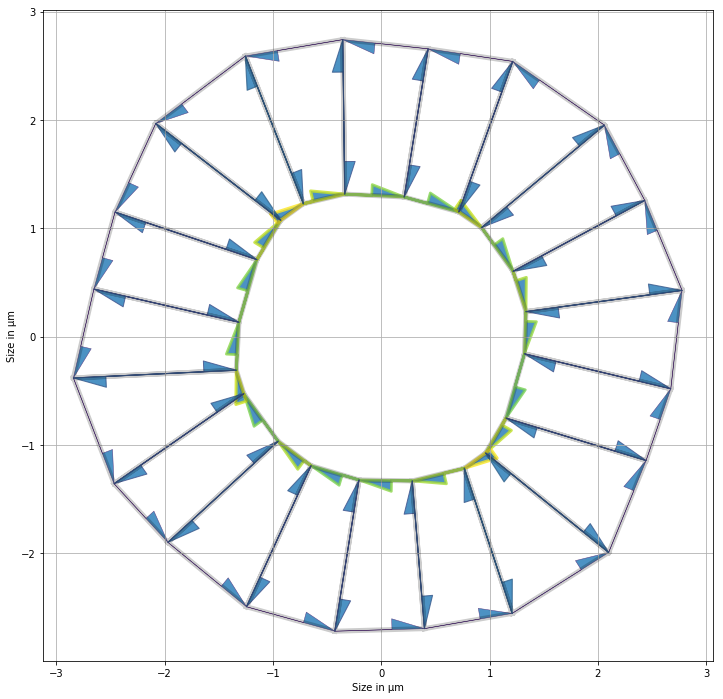

In [3]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [4]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.101
1     0.115
2     0.126
3     0.110
4     0.105
5     0.102
6     0.112
7     0.102
8     0.118
9     0.105
10    0.104
11    0.115
12    0.127
13    0.116
14    0.106
15    0.103
16    0.117
17    0.105
18    0.111
19    0.107
20    0.010
21    0.011
22    0.012
23    0.011
24    0.010
25    0.010
26    0.011
27    0.010
28    0.011
29    0.010
      ...  
50    0.030
51    0.035
52    0.040
53    0.035
54    0.030
55    0.030
56    0.035
57    0.030
58    0.035
59    0.030
60    0.030
61    0.035
62    0.040
63    0.035
64    0.030
65    0.030
66    0.035
67    0.030
68    0.035
69    0.030
70    0.030
71    0.035
72    0.040
73    0.035
74    0.030
75    0.030
76    0.035
77    0.030
78    0.035
79    0.030
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.037466
1     0.042980
2     0.047452
3     0.041083
4     0.039120
5     0.037130
6     0.042399
7     0.037119
8     0.043188
9     0.038093
10    0.038654
11    0.042510
12    0.047137
13    0.042130

Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [5]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  78 
Dimension of A:  81


## Matrice sans modification

Apical tensions:  [0.00218507 0.00194426 0.00319998 0.00180642 0.00177677 0.0017477
 0.00188348 0.00569949 0.00396838 0.00180909 0.28236276 0.03655472
 0.00159496 0.00150456 0.00593747 0.00166839 0.00159585 0.00207799
 0.00159716 0.00305703] 
Basal tensions:  [5.41298992e-04 9.16086515e-05 9.18015945e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.71809926e-03
 1.55980570e-03 0.00000000e+00 2.67569851e-01 2.98155685e-02
 0.00000000e+00 0.00000000e+00 4.12530530e-03 2.02180567e-04
 0.00000000e+00 5.43522621e-04 0.00000000e+00 1.18752183e-03] 
Lateral tensions:  [0.00188718 0.00136243 0.00176826 0.00177555 0.00106367 0.00105044
 0.00114451 0.00305604 0.00348141 0.00190868 0.13608716 0.15016835
 0.01469458 0.00102794 0.00285546 0.00316347 0.00103437 0.00118303
 0.00125312 0.00158537] 
Area elasticity:  [0.00198355 0.00144574 0.00294254 0.00127432 0.00126968 0.00122999
 0.00135008 0.00661197 0.00384291 0.001236   0.39974471 0.04736251
 0.00117853 0.00109185 0.00721489 0.

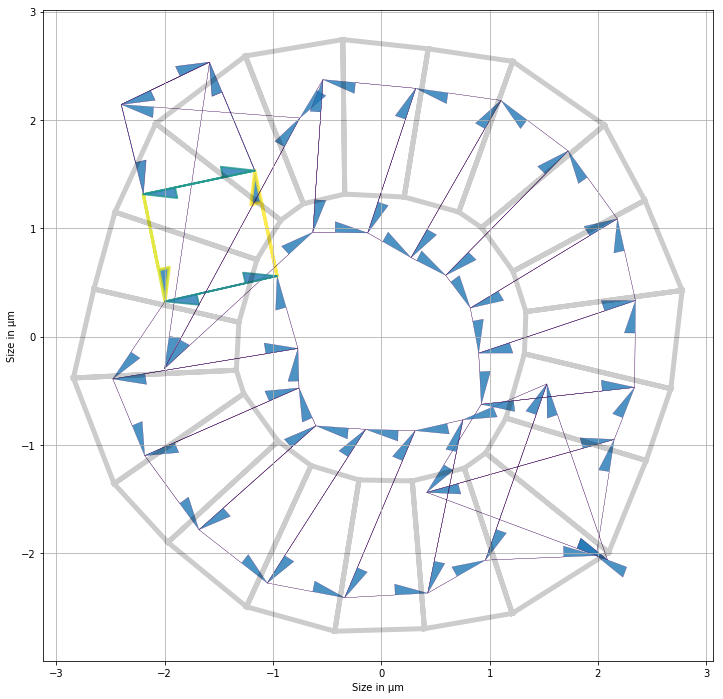

In [6]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
no_mod_mat, residuals = nnls(matrix, constant)
organo3_no_mod_mat = organo3.copy()
organo3_no_mod_mat.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_no_mod_mat,
                                                                     no_mod_mat[:3*organo3.Nf])
organo3_no_mod_mat.face_df.loc[:, 'prefered_area'] = organo3_no_mod_mat.face_df.area + no_mod_mat[3*organo3.Nf:
                                                                                                  4*organo3.Nf]
organo3_no_mod_mat.settings['lumen_prefered_vol'] = no_mod_mat[-1]
Solver.find_energy_min(organo3_no_mod_mat, geom, model)
print_tensions(organo3_no_mod_mat, organo3)
print('Apical tensions: ', no_mod_mat[organo3.apical_edges],
      '\nBasal tensions: ', no_mod_mat[organo3.basal_edges],
      '\nLateral tensions: ', no_mod_mat[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', no_mod_mat[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', no_mod_mat[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-no_mod_mat),
      '\nNNLS residuals: ', residuals)

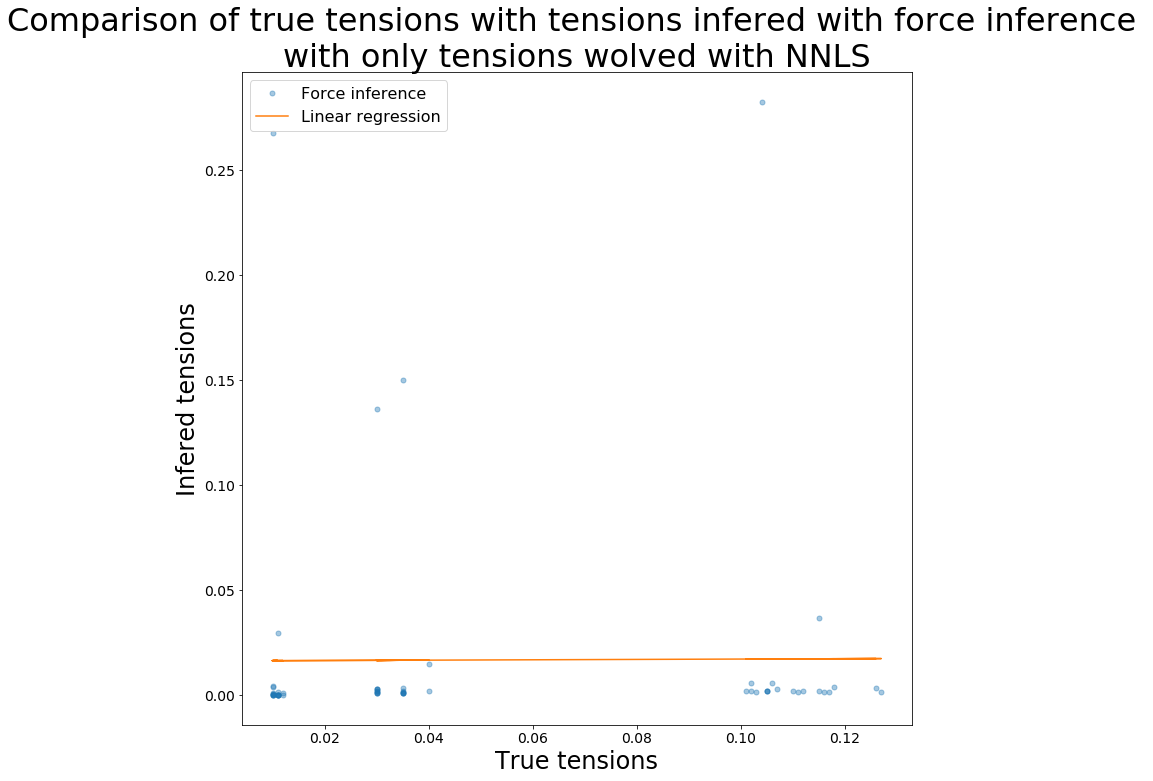

R value : 0.006813302782176759 
Standard error : 0.04719802477077426


In [7]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  no_mod_mat[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec une contrainte sur le rapport des moyennes des tensions

Apical tensions:  [0.0364762  0.03851553 0.04034484 0.03724886 0.03663195 0.03606083
 0.03741535 0.03603109 0.03910957 0.0371719  0.03693465 0.03842715
 0.04049846 0.03866386 0.03733457 0.03686916 0.03896081 0.03655173
 0.03756239 0.03750874] 
Basal tensions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lateral tensions:  [0.01054375 0.01118302 0.01637276 0.01523862 0.01098376 0.0107467
 0.01266121 0.01170198 0.01247249 0.01366675 0.01007062 0.01154686
 0.01576105 0.01581467 0.01183941 0.00979281 0.01287894 0.01314815
 0.0119752  0.01305915] 
Area elasticity:  [0.01405095 0.01559143 0.01690975 0.01469423 0.01399501 0.01333489
 0.01461293 0.01327434 0.01506557 0.01388413 0.01433825 0.01531146
 0.01652733 0.01504856 0.01416069 0.01355407 0.01495818 0.01361772
 0.0145245  0.01437905] 
Lumen area elasticity:  0.06303914729805847 
Distance to solution:  0.3643311539859371 
NNLS residuals:  0.004461523914348266


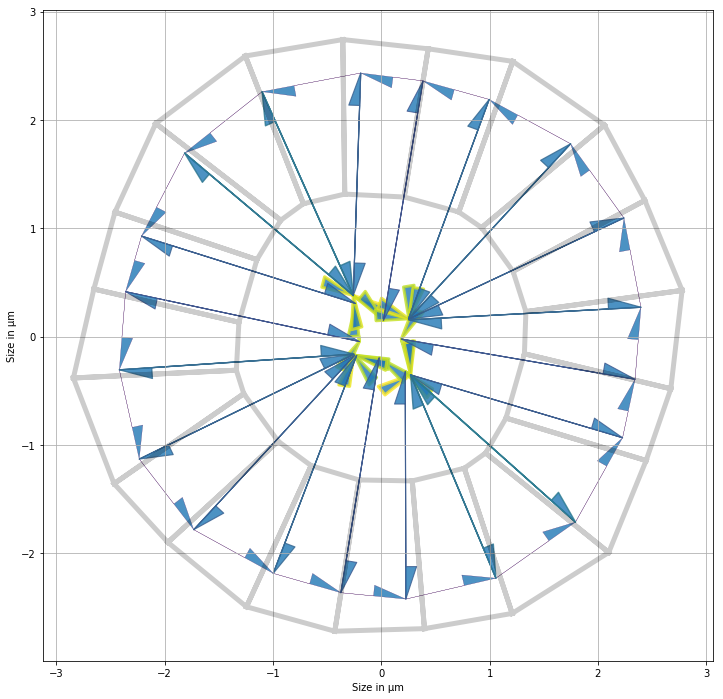

In [8]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
avg_line1 = np.concatenate((np.ones(organo3.Nf),
                            np.zeros(organo3.Nf),
                            -3*np.ones(organo3.Nf),
                            np.zeros(organo3.Nf+1)))
avg_cste = [0]
matrix = np.vstack((matrix, avg_line1))
constant = np.concatenate((constant, avg_cste))
mat_mean_cst, residuals = nnls(matrix, constant)
organo3_mean_cst = organo3.copy()
organo3_mean_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mean_cst,
                                                                   mat_mean_cst[:3*organo3.Nf])
organo3_mean_cst.face_df.loc[:, 'prefered_area'] = organo3_mean_cst.face_df.area + mat_mean_cst[3*organo3.Nf:
                                                                                              4*organo3.Nf]
organo3_mean_cst.settings['lumen_prefered_vol'] = mat_mean_cst[-1]
Solver.find_energy_min(organo3_mean_cst, geom, model)
print_tensions(organo3_mean_cst, organo3)
print('Apical tensions: ', mat_mean_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_mean_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_mean_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_mean_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_mean_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_mean_cst),
      '\nNNLS residuals: ', residuals)

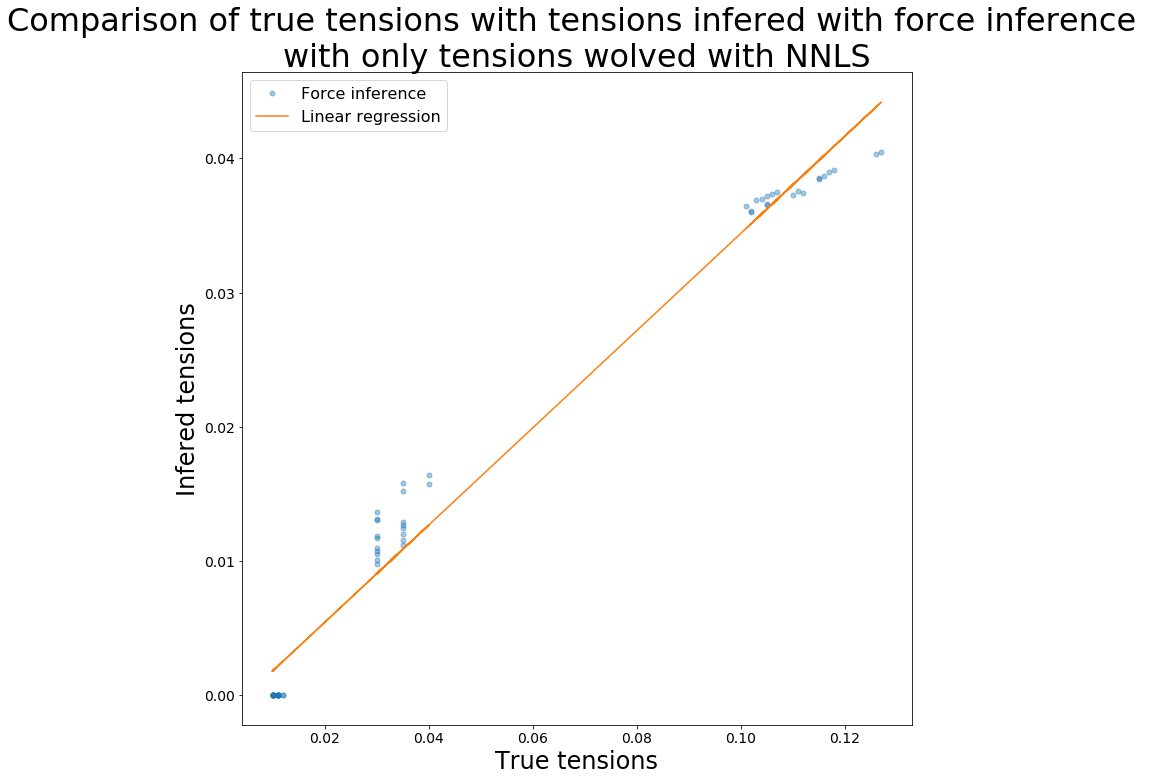

R value : 0.9901377977777298 
Standard error : 0.0019091413469679978


In [9]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_mean_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec la dernière ligne "splitée" en trois contraintes
On supprime la contrainte $$\sum \Lambda_{i,j} = c$$ On ajoute les contraintes $$\Lambda_0 + \Lambda_1 + \Lambda_2 = c_1$$ $$\Lambda_3 + \Lambda_4 + \Lambda_5 = c_2$$ $$\Lambda_6 + \Lambda_7 + \Lambda_8 = c_3$$ Où $c_1+c_2+c_3=c$

Apical tensions:  [0.09694784 0.10184508 0.10644348 0.09868767 0.0971887  0.09583991
 0.09914943 0.09585577 0.10351761 0.09872861 0.09820915 0.10182778
 0.10703443 0.10238504 0.09909736 0.09794652 0.10308588 0.09707579
 0.09951133 0.09938232] 
Basal tensions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lateral tensions:  [0.02442299 0.026132   0.04021769 0.03704788 0.02556928 0.02503221
 0.0301981  0.02765207 0.02995211 0.033258   0.02331941 0.02717158
 0.03869045 0.03889143 0.02803302 0.02248356 0.0309514  0.03170409
 0.0284259  0.03131883] 
Area elasticity:  [0.03345994 0.03738738 0.04075716 0.03508848 0.03312656 0.0315255
 0.03463667 0.03160572 0.03608735 0.03322811 0.03435185 0.0369115
 0.04007369 0.03625054 0.03381841 0.03229941 0.03572085 0.03243637
 0.03452723 0.03412598] 
Lumen area elasticity:  0.18631391376131196 
Distance to solution:  0.1846128626613823 
NNLS residuals:  0.014051088481977569


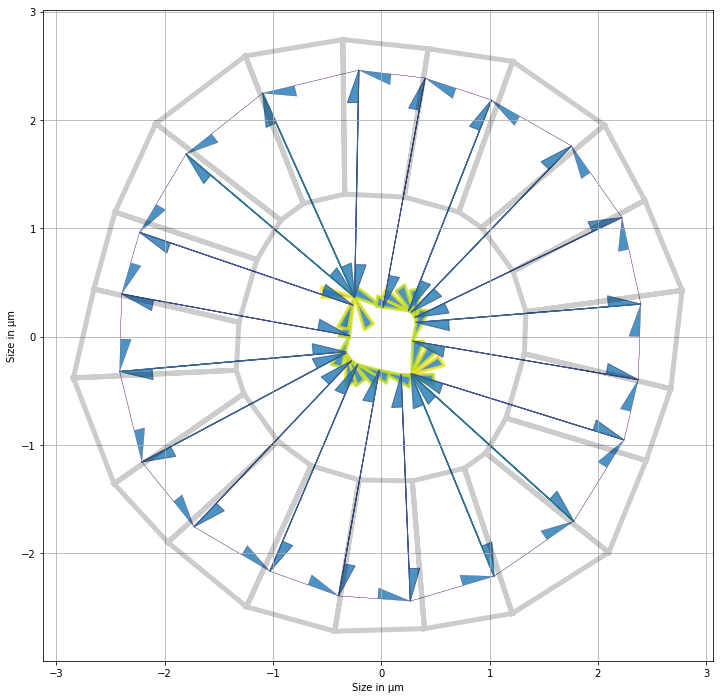

In [10]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = organo3.Nf*0.1
constant = np.concatenate((constant, [0, organo3.Nf*0.03]))
matrix = _coef_matrix(organo3, sup_param='areas')
matrix[-1] = np.concatenate((np.ones(organo3.Nf),
                             np.zeros(3*organo3.Nf+1)))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(organo3.Nf), np.ones(organo3.Nf), np.zeros(2*organo3.Nf+1))),
                    np.concatenate((np.zeros(2*organo3.Nf), np.ones(organo3.Nf), np.zeros(organo3.Nf+1)))))
mat_3_cst, residuals = nnls(matrix, constant)
organo3_mat_3_cst = organo3.copy()
organo3_mat_3_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mat_3_cst,
                                                                    mat_3_cst[:3*organo3.Nf])
organo3_mat_3_cst.face_df.loc[:, 'prefered_area'] = organo3_mat_3_cst.face_df.area + mat_3_cst[3*organo3.Nf:
                                                                                                4*organo3.Nf]
organo3_mat_3_cst.settings['lumen_prefered_vol'] = mat_3_cst[-1]
Solver.find_energy_min(organo3_mat_3_cst, geom, model)
print_tensions(organo3_mat_3_cst, organo3)
print('Apical tensions: ', mat_3_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_3_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_3_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_3_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_3_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_3_cst),
      '\nNNLS residuals: ', residuals)

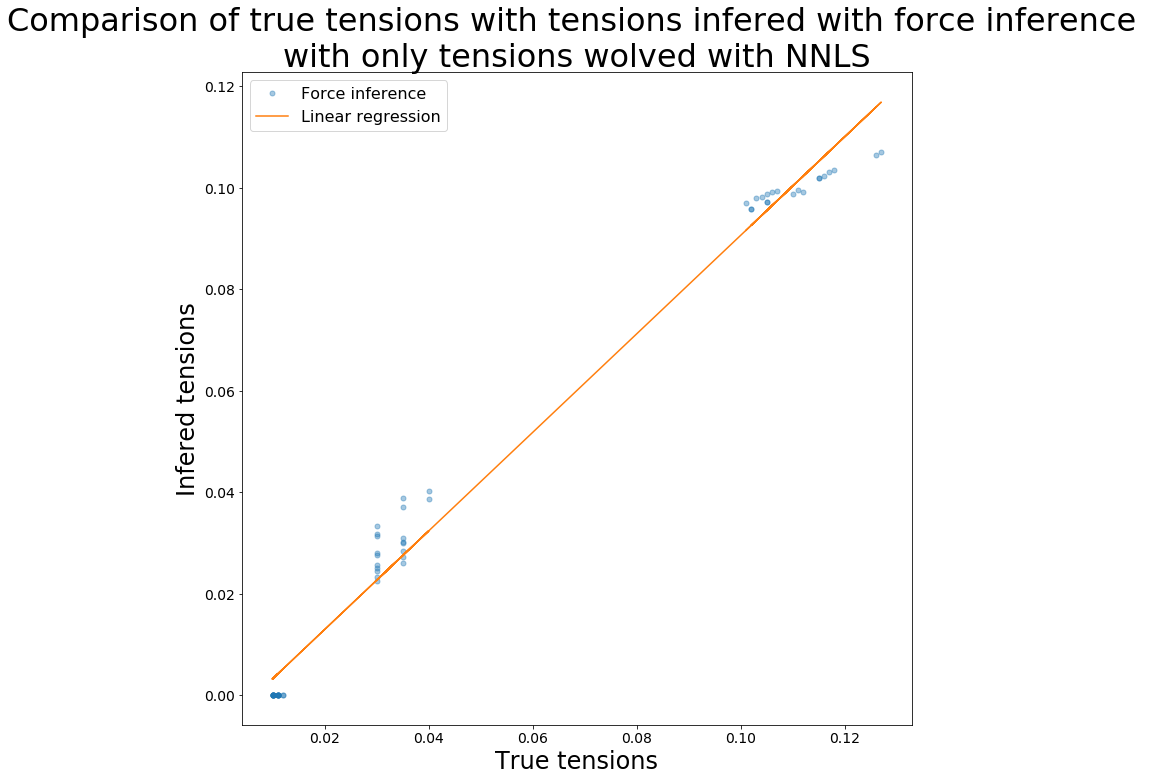

R value : 0.9934903403018441 
Standard error : 0.004147171377796892


In [11]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_3_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec la dernière ligne "splitée" en deux contraintes
On constate qu'il suffit d'ajouter deux contraintes pour obtenir le résultat attendu.

Apical tensions:  [0.00033845 0.00028829 0.00028744 0.00028846 0.00033237 0.00029558
 0.00029774 0.0002994  0.00029195 0.00028765 0.00033865 0.00028019
 0.00027857 0.00028063 0.00033861 0.00029239 0.00029604 0.00029273
 0.00029593 0.00029657] 
Basal tensions:  [4.53152728e-05 0.00000000e+00 0.00000000e+00 4.61090886e-06
 4.16456157e-05 8.59604835e-06 8.77216960e-06 1.44839893e-05
 6.00638548e-06 6.28418177e-06 5.69481587e-05 7.14449442e-06
 5.27116413e-06 7.53058797e-06 5.40528085e-05 6.10352260e-06
 4.49015667e-06 3.94097577e-06 3.90033153e-06 4.43775435e-06] 
Lateral tensions:  [0.00000000e+00 0.00000000e+00 1.38871086e-05 1.01798474e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.40945463e-07 0.00000000e+00 0.00000000e+00
 3.18869322e-06 5.94508538e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] 
Area elasticity:  [6.31459294e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.11764120e-05 0.00000000e

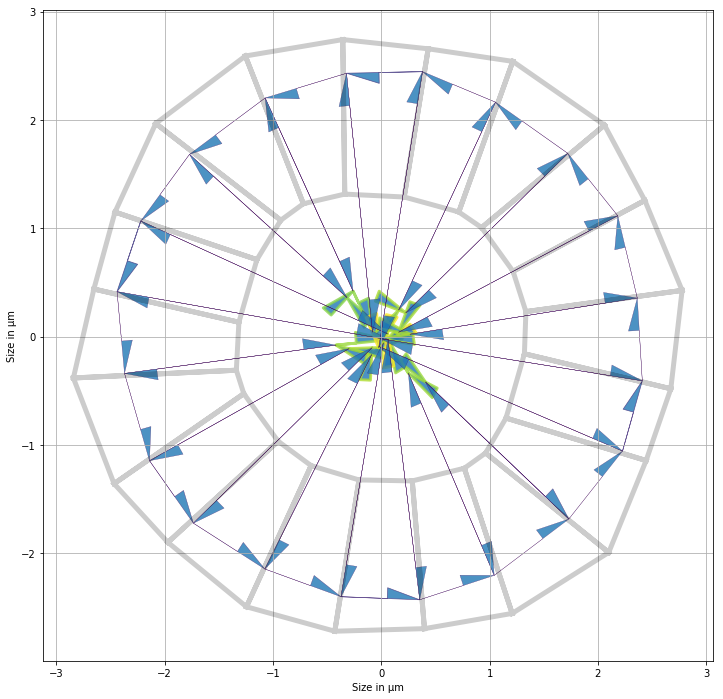

In [12]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.006
constant = np.concatenate((constant, [0]))
matrix = _coef_matrix(organo3, sup_param='areas')
matrix[-1] = np.concatenate((np.ones(organo3.Nf),
                             np.zeros(3*organo3.Nf+1)))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(2*organo3.Nf), np.ones(organo3.Nf), np.zeros(organo3.Nf+1)))))
mat_2_cst, residuals = nnls(matrix, constant)
organo3_mat_2_cst = organo3.copy()
organo3_mat_2_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mat_2_cst,
                                                                    mat_2_cst[:3*organo3.Nf])
organo3_mat_2_cst.face_df.loc[:, 'prefered_area'] = organo3_mat_2_cst.face_df.area + mat_2_cst[3*organo3.Nf:
                                                                                                4*organo3.Nf]
organo3_mat_2_cst.settings['lumen_prefered_vol'] = mat_2_cst[-1]
Solver.find_energy_min(organo3_mat_2_cst, geom, model)
print_tensions(organo3_mat_2_cst, organo3)
print('Apical tensions: ', mat_2_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_2_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_2_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_2_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_2_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_2_cst),
      '\nNNLS residuals: ', residuals)

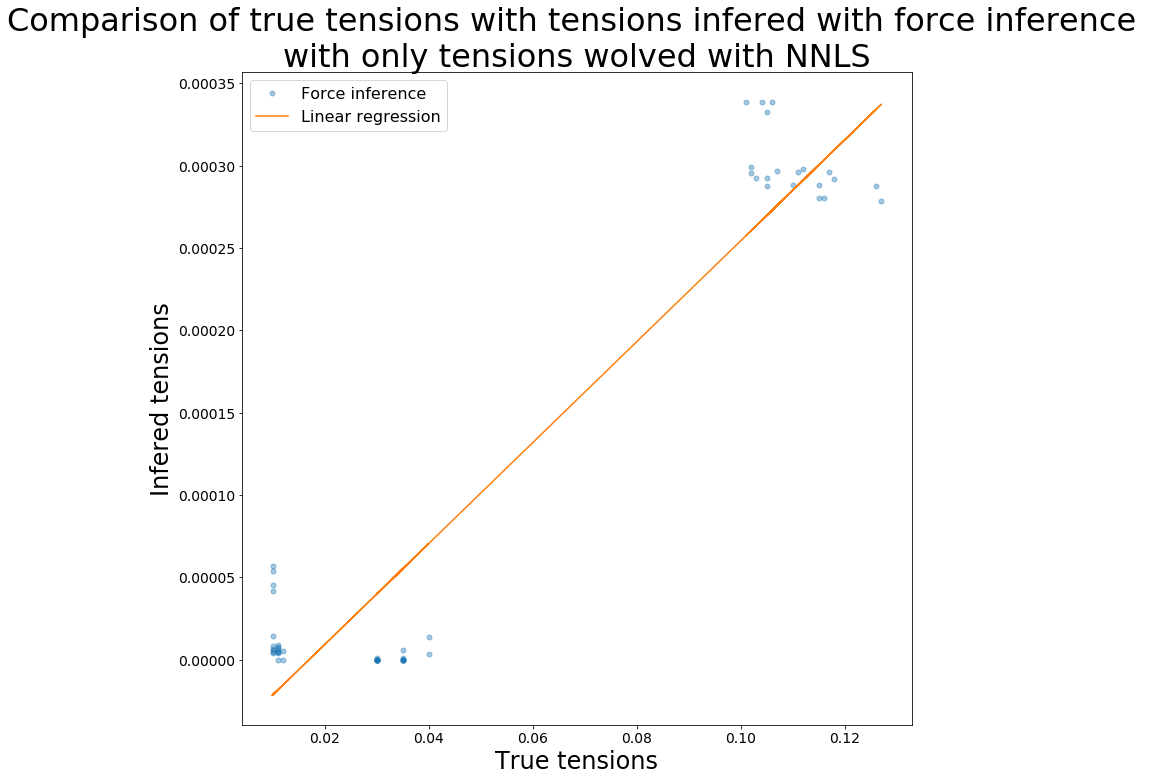

R value : 0.9512119092636839 
Standard error : 3.704067582229532e-05


In [13]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_2_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec deux contraintes d'égalité
Ici on pose les contraintes $\Lambda_1 = \Lambda_2$ et $\Lambda_6 = \Lambda_7$

Apical tensions:  [0.00211749 0.00238481 0.00238505 0.00183864 0.00180961 0.00178127
 0.00192173 0.00569145 0.00394692 0.0018547  0.28209879 0.03671805
 0.00165377 0.00156213 0.00631814 0.00171647 0.00166587 0.00218557
 0.00167178 0.00306293] 
Basal tensions:  [4.10001268e-04 4.10076434e-04 2.66848450e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.67501278e-03
 1.50736257e-03 0.00000000e+00 2.67273283e-01 2.99099135e-02
 0.00000000e+00 0.00000000e+00 4.42210448e-03 1.90086494e-04
 0.00000000e+00 5.80066910e-04 0.00000000e+00 1.12900236e-03] 
Lateral tensions:  [0.00183291 0.00152053 0.00159619 0.00141375 0.00108883 0.00107463
 0.00117053 0.00305897 0.00346095 0.00191104 0.13596435 0.15010755
 0.01477348 0.00106464 0.00302899 0.0033481  0.00106812 0.00123804
 0.00131373 0.00160107] 
Area elasticity:  [0.00183336 0.00199179 0.00188486 0.00130719 0.0013009  0.00125942
 0.00138212 0.0065785  0.00379181 0.00126813 0.39933728 0.04754566
 0.00121881 0.00113099 0.00769686 0

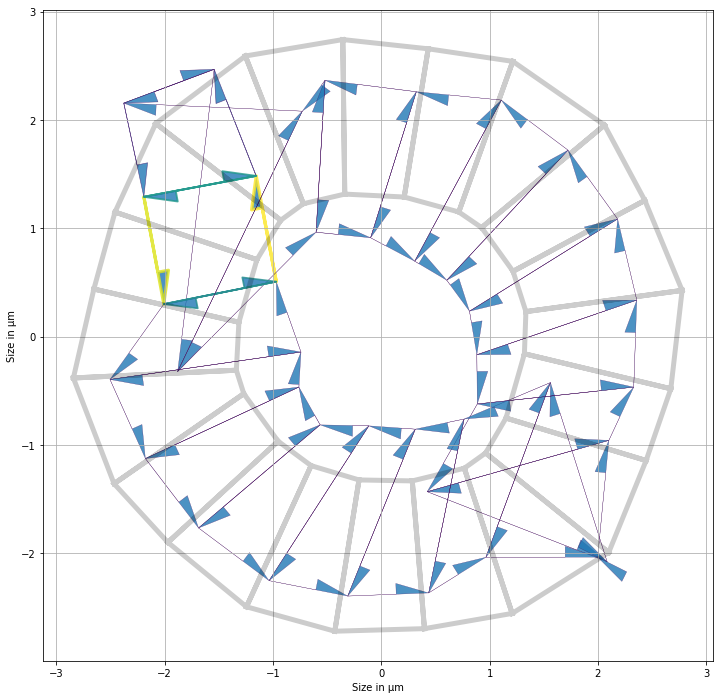

In [14]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant = np.concatenate((constant, [0, 0]))
matrix = np.vstack((matrix,
                    np.concatenate(([0, 1, -1], np.zeros(4*organo3.Nf-2))),
                    np.concatenate((np.zeros(organo3.Nf), [1, -1], np.zeros(3*organo3.Nf-1)))))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

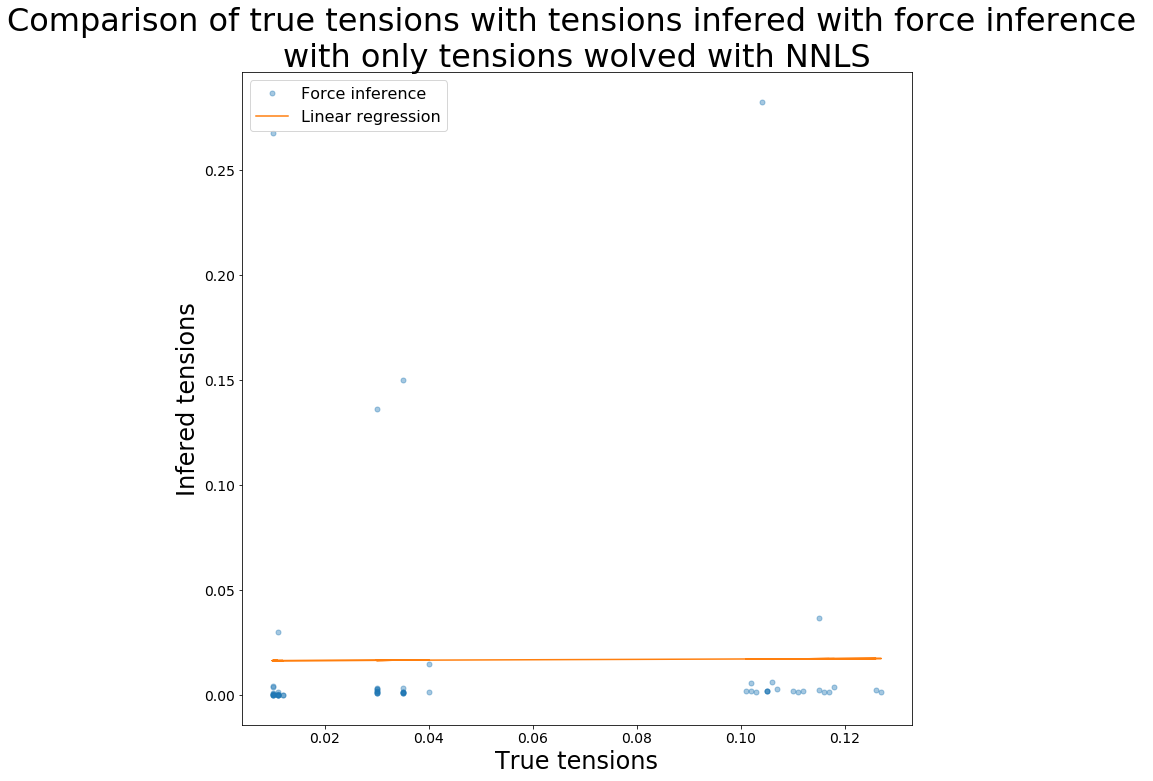

R value : 0.007044162126654247 
Standard error : 0.04715380498569921


In [15]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec cst somme des élasticité = 0

Apical tensions:  [0.00038174 0.00037983 0.00038036 0.00037713 0.00038189 0.00038192
 0.00038366 0.00038109 0.00038998 0.0003856  0.00038286 0.0003806
 0.0003823  0.00038239 0.0003856  0.00038631 0.00038981 0.00038168
 0.00038448 0.00038631] 
Basal tensions:  [6.51687797e-06 0.00000000e+00 0.00000000e+00 1.05285710e-06
 2.04042125e-06 2.56255684e-07 0.00000000e+00 3.55232372e-06
 0.00000000e+00 8.44358155e-07 5.91769154e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.56445527e-06 4.36677236e-06
 0.00000000e+00 8.22531948e-07 0.00000000e+00 0.00000000e+00] 
Lateral tensions:  [5.03675112e-05 5.12488551e-05 8.49865881e-05 7.67877027e-05
 5.25044114e-05 5.57426074e-05 7.08638139e-05 6.32154304e-05
 6.55875163e-05 7.49387866e-05 4.71468590e-05 5.38945942e-05
 8.02109638e-05 8.15785708e-05 5.67988653e-05 4.58288835e-05
 6.86364585e-05 7.16627420e-05 6.44690563e-05 7.10600163e-05] 
Area elasticity:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lumen area elasticity:  7.

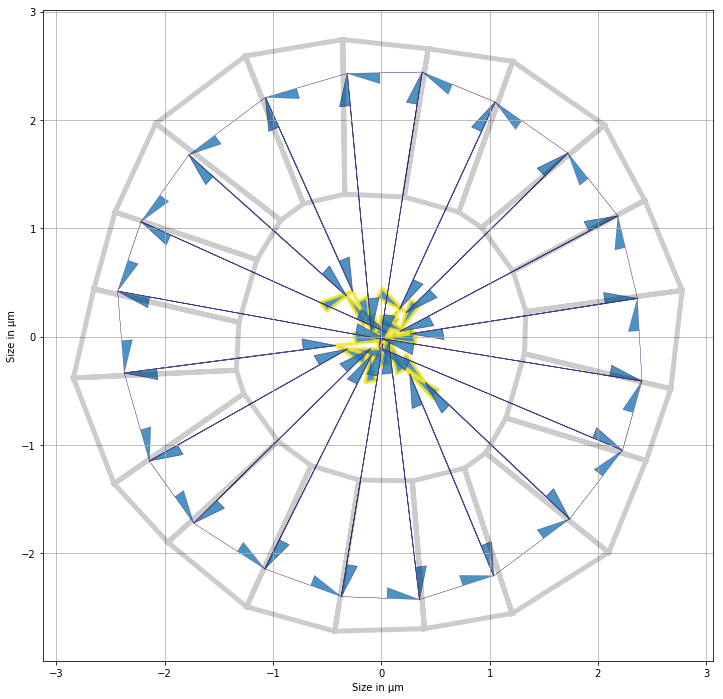

In [16]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
constant = np.concatenate((constant, [0]))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(3*organo3.Nf), np.ones(organo3.Nf+1)))))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

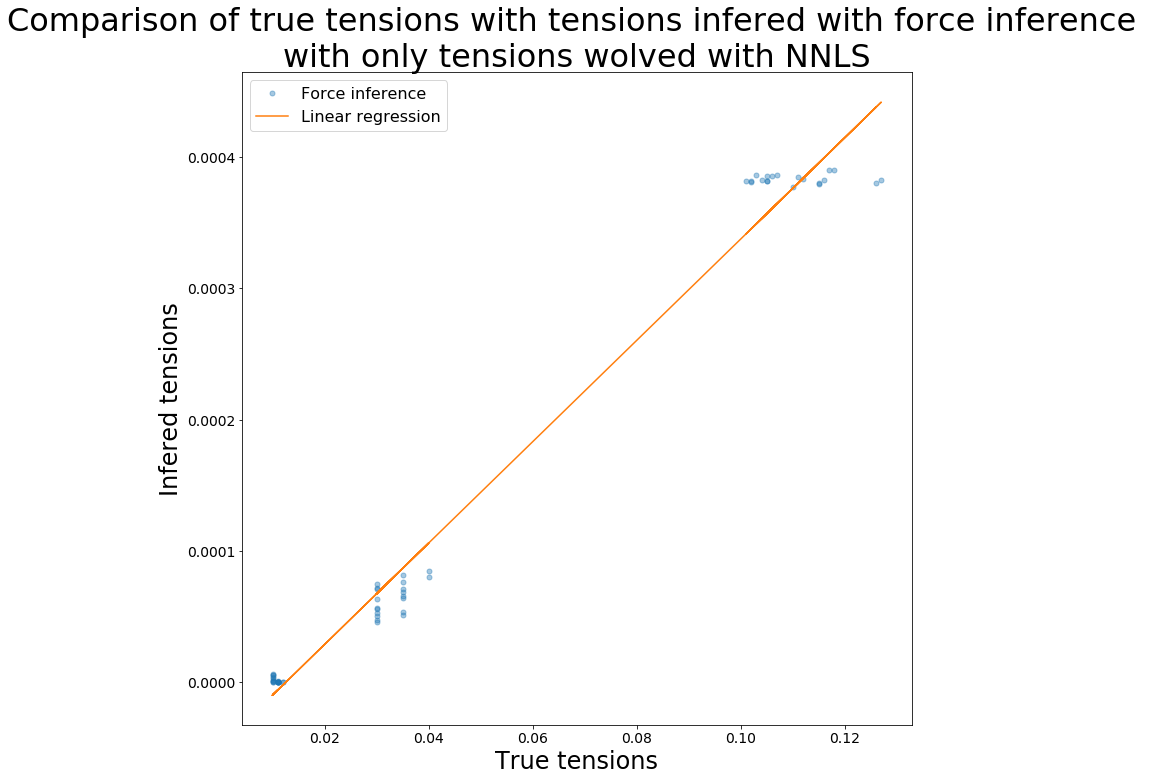

R value : 0.9920500335940923 
Standard error : 1.8230235475672954e-05


In [17]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec somme des tensions constantes dans chaque cellule

Apical tensions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Basal tensions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lateral tensions:  [0.00512397 0.00616064 0.00867491 0.00737558 0.00555923 0.0063131
 0.00681846 0.00614478 0.00708031 0.0071072  0.00470475 0.00663254
 0.00883029 0.00802819 0.00566163 0.00549496 0.00756845 0.00680843
 0.00606109 0.00703685] 
Area elasticity:  [0.0888319  0.0854709  0.08221455 0.08492113 0.08732962 0.08567931
 0.08658244 0.08613434 0.08414932 0.08559094 0.08911613 0.08500605
 0.08152999 0.08309537 0.08747607 0.08667506 0.08424532 0.08533266
 0.08626995 0.0861587 ] 
Lumen area elasticity:  0.3556165792475579 
Distance to solution:  0.6443417590280797 
NNLS residuals:  0.4148892206008521


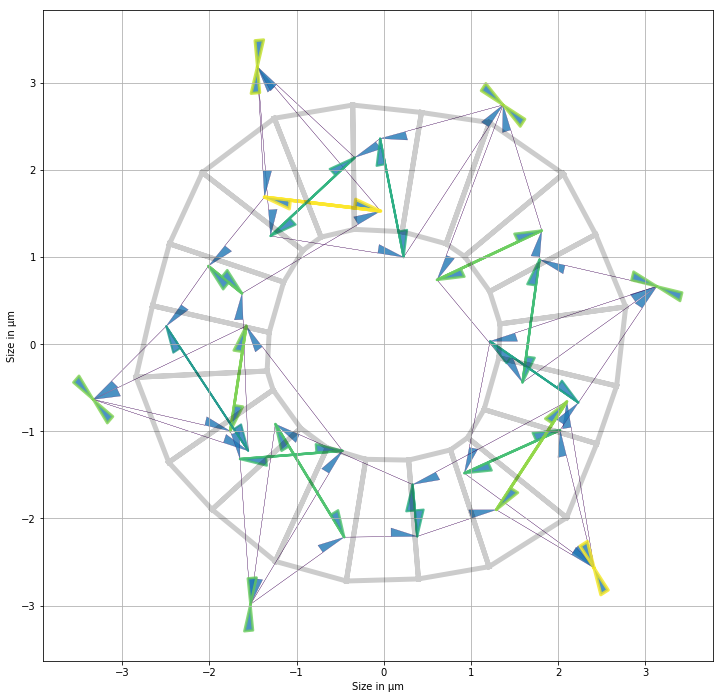

In [18]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
avg_cste = [0.15]*organo3.Nf
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i))
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

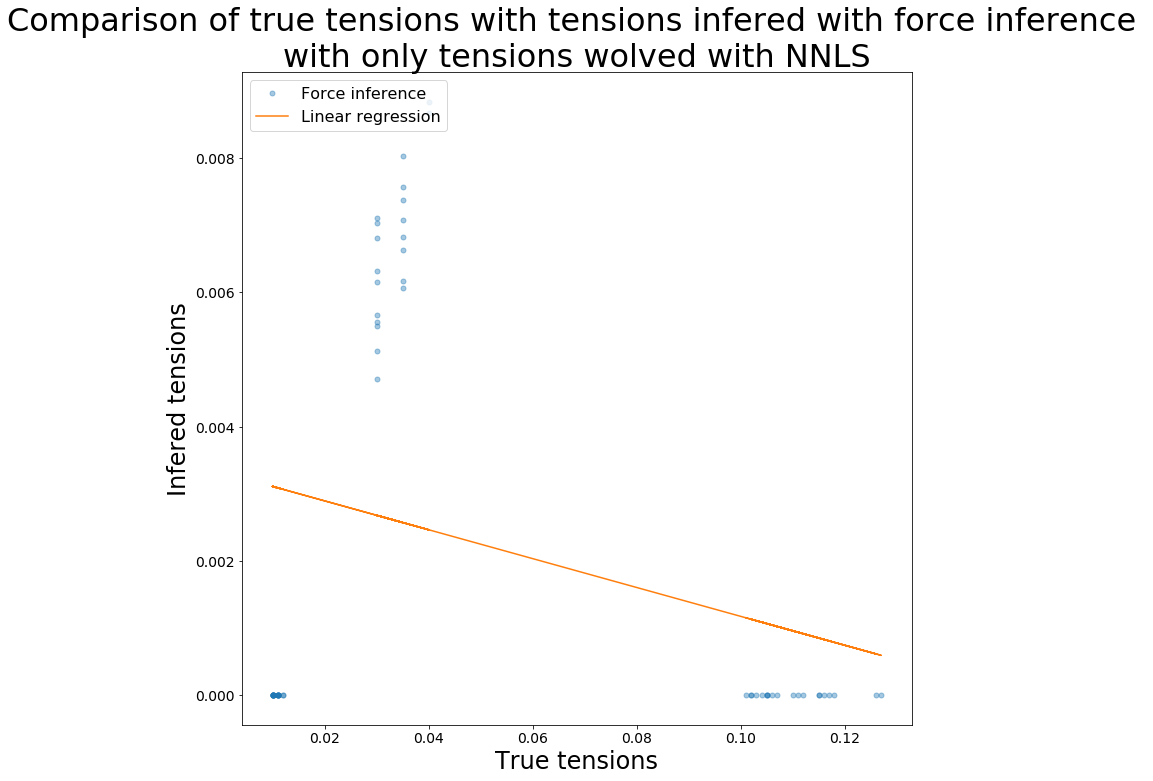

R value : -0.2888955400108514 
Standard error : 0.0026534736157125694


In [19]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec les pressions

Apical tensions:  [0.04161615 0.04137369 0.04132476 0.04211428 0.04313264 0.04299938
 0.04310787 0.04278751 0.04379294 0.04415462 0.04390298 0.04282461
 0.04204486 0.04218545 0.04263645 0.04282075 0.04248063 0.04163778
 0.04196251 0.04215804] 
Basal tensions:  [0.00075604 0.         0.         0.         0.         0.
 0.         0.00040805 0.         0.         0.0001398  0.
 0.         0.         0.00038072 0.         0.         0.00011249
 0.         0.        ] 
Lateral tensions:  [0.00598492 0.00606806 0.00956435 0.0087718  0.00637091 0.00676178
 0.00837301 0.0075398  0.00773634 0.00879973 0.00589919 0.00658222
 0.00922177 0.00931222 0.0067403  0.00559106 0.00794645 0.00818992
 0.00747377 0.0081471 ] 
Area elasticity:  [0.         0.         0.         0.00179352 0.00095947 0.
 0.         0.         0.         0.00106933 0.         0.00140374
 0.00148283 0.         0.         0.         0.00108124 0.
 0.         0.         0.        ] 
Lumen area elasticity:  0.0 
Distance to solu

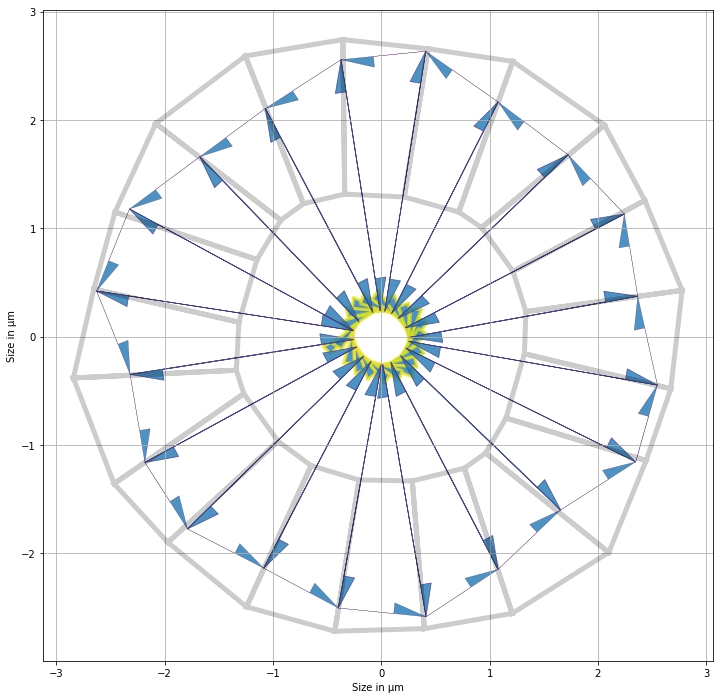

In [20]:
matrix = _coef_matrix(organo3, sup_param='pressions')
constant = _right_side(organo3, matrix)
mat_pressions, residuals = nnls(matrix, constant)
organo3_pressions = organo3.copy()
organo3_pressions.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_pressions,
                                                                    mat_pressions[:3*organo3.Nf])
Solver.find_energy_min(organo3_pressions, geom, model)
print_tensions(organo3_pressions, organo3)
print('Apical tensions: ', mat_pressions[organo3.apical_edges],
      '\nBasal tensions: ', mat_pressions[organo3.basal_edges],
      '\nLateral tensions: ', mat_pressions[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_pressions[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_pressions[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data[:organo3.Nf*3]-mat_pressions[:organo3.Nf*3]),
      '\nNNLS residuals: ', residuals)

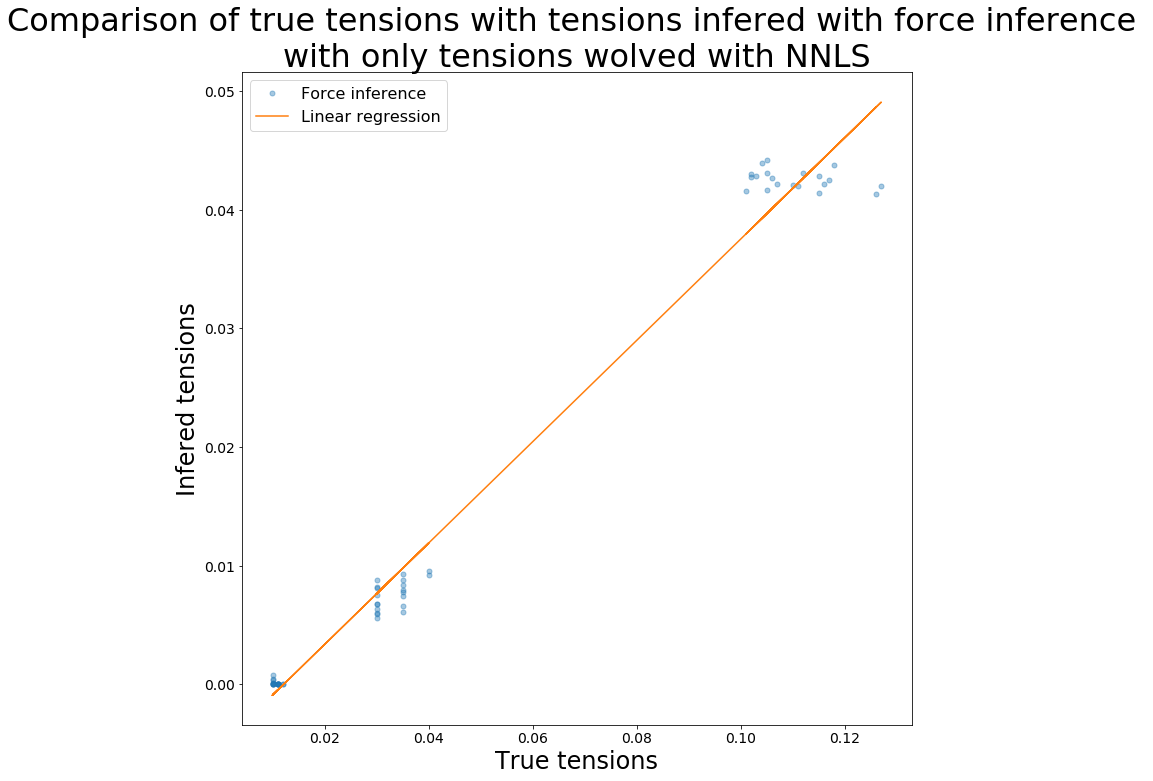

R value : 0.9916708713720854 
Standard error : 0.0020668596269718268


In [21]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_pressions[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

On conserve la symétrie mais on n'obtient pas le résultat attendu.

Remarque : les relations entre les lignes de A sont conservées avec les coefficients des pressions

In [22]:
matrix[1]+matrix[2]+matrix[3]+matrix[4]+matrix[5]

array([ 0.27517678,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.95833594,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.95697717,  0.77794151,  0.31318774,  0.08226434,
       -0.15817158,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.19604961,  0.45886563,  0.66994286,  0.68182122,
        0.69816607,  0.        ,  0.        ,  0.        ,  0.  

In [23]:
-matrix[0]

array([ 0.27517678, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.03546277,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.97259224, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.16152745, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [24]:
matrix[7]+matrix[8]+matrix[9]+matrix[10]+matrix[11]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.80378719,  0.        ,  0.        ,  0.        ,
        0.        ,  0.51804212,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.7366982 , -0.82162637, -0.99886143,
       -0.97476504, -0.94812925,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.46677886,  0.41544092,  0.03

In [25]:
-matrix[6]

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.95833594,  0.80378719, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.41643447, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.65127133, -0.        , -0.        , -0.  